# Shapley Value Attribution for Tabular Models

This document provides a formal, academic presentation of Shapley value attributions for feed-forward neural networks on tabular data. We derive the Shapley definition, present an unbiased Monte Carlo estimator for ground-truth values, describe the SHAP DeepExplainer methodology, and outline a side-by-side bar-chart comparison protocol.

## 1. Introduction
Interpreting feature contributions in tabular models is essential for model transparency. Shapley values, originating from cooperative game theory, offer a principled way to assign each feature its average marginal impact. We demonstrate how to compute exact Shapley attributions via Monte Carlo sampling and approximate them efficiently using the SHAP DeepExplainer.

## 2. Formal Definition
Let:

- $F$ be the number of features  
- $N = \{1, 2, \dots, F\}$ the feature index set  
- $x \in \mathbb{R}^F$ a specific input vector  
- $f : \mathbb{R}^F \to \mathbb{R}$ the model’s scalar output  
- $b \in \mathbb{R}^F$ the baseline vector (e.g., feature means)

For any coalition $S \subseteq N$, define the “masked” input:

$$
x_S[i] =
\begin{cases}
x_i, & \text{if } i \in S \\
b_i, & \text{if } i \notin S
\end{cases}
$$

The Shapley value for feature $i$ is:

$$
\phi_i =
\sum_{S \subseteq N \setminus \{i\}}
\frac{|S|! \, (F - |S| - 1)!}{F!}
\left[ f(x_{S \cup \{i\}}) - f(x_S) \right]
$$

This formula ensures fair averaging of each feature’s marginal contribution across all subsets $S$.

## 3. Unbiased Monte Carlo Estimation
Exact evaluation requires $2^F$ function calls. Instead, approximate by sampling $M$ random coalitions:

1. For $m = 1, \dots, M$, draw $S_m \subseteq N \setminus \{i\}$ by including each feature $j \ne i$ with probability 0.5.  
2. Compute marginal contribution:  
   $$
   d_m = f(x_{S_m \cup \{i\}}) - f(x_{S_m})
   $$
3. Estimate:  
   $$
   \phi_i^{\mathrm{MC}} \approx \frac{1}{M} \sum_{m=1}^M d_m
   $$

By the law of large numbers, $\phi_i^{\mathrm{MC}} \to \phi_i$ as $M \to \infty$.

## 4. SHAP DeepExplainer Method
SHAP’s DeepExplainer uses a background dataset $X_b = \{x'^{(1)}, \dots, x'^{(K)}\}$ to approximate the expected output:

$$
\mathbb{E}[f(x')] \approx \frac{1}{K} \sum_{k=1}^K f(x'^{(k)})
$$

It then computes attributions $\psi_i(x)$ satisfying:

$$
f(x) = \mathbb{E}[f(x')] + \sum_{i=1}^F \psi_i(x)
$$

Non‐linear activations are linearized around each background sample, and backpropagation aggregates contributions. The parameter `check_additivity=False` can be used to relax strict summation checks when necessary.

## 5. Comparative Visualization Protocol
To assess fidelity of $\psi$ against $\phi^{\mathrm{MC}}$:

1. Choose a test instance $x$  
2. Compute $\phi^{\mathrm{MC}}(x) \in \mathbb{R}^F$ via Monte Carlo  
3. Compute $\psi(x) \in \mathbb{R}^F$ with DeepExplainer  
4. Plot two side‐by‐side bar charts:
   - **X‐axis:** feature index $i$  
   - **Y‐axis:** attribution magnitude  
   - **Left chart:** $\phi_i^{\mathrm{MC}}$  
   - **Right chart:** $\psi_i$

Visual agreement indicates high fidelity of the DeepExplainer approximation.

## 6. Discussion
This exposition demonstrates that Shapley attributions apply seamlessly to tabular neural networks. The Monte Carlo estimator provides unbiased “ground truth,” while DeepExplainer offers an efficient, differentiable approximation. Comparative bar‐chart analysis highlights any discrepancies and guides practitioners in evaluating attribution reliability.


/home/niyang/repos/enhanced_shap/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


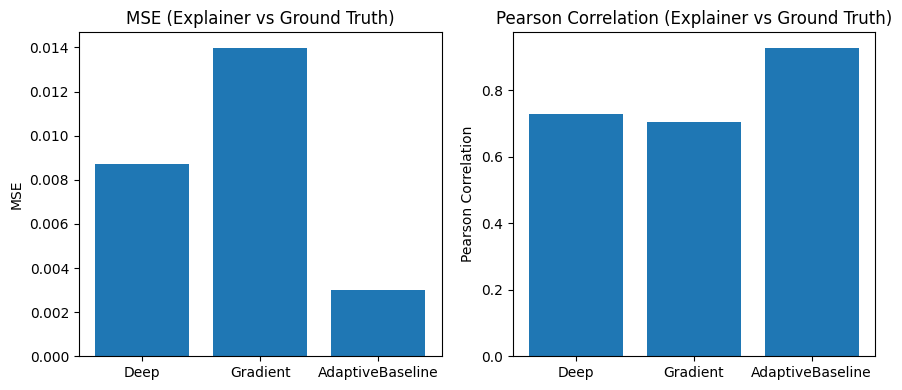

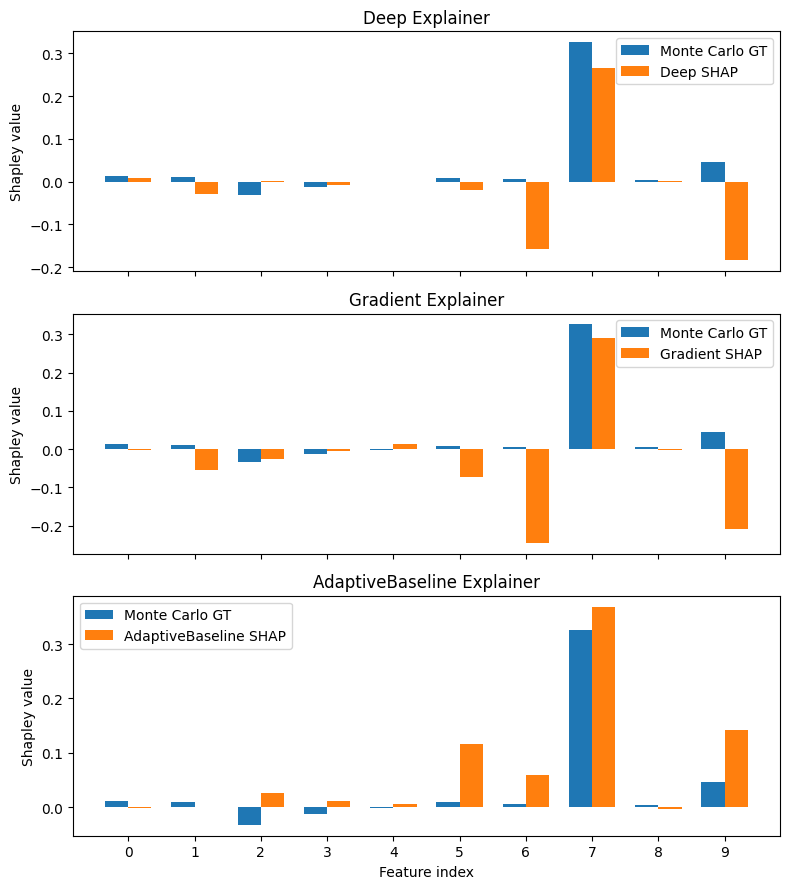

In [1]:
import torch
import numpy as np
import shap
from scipy.stats import pearsonr

from shap_enhanced.tools.datasets import generate_synthetic_tabular
from shap_enhanced.tools.predefined_models import TabularMLP
from shap_enhanced.tools.evaluation import compute_shapley_gt_tabular
from shap_enhanced.tools.visulization import plot_mse_pearson, plot_feature_comparison

from shap_enhanced.explainers.ABSHAP import AdaptiveBaselineSHAPExplainer

# 1. Generate synthetic sparse tabular data (nonlinear by default)
n_samples = 500
n_features = 10
X, y, true_w = generate_synthetic_tabular(
    n_samples=n_samples,
    n_features=n_features,
    sparse=True,
    model_type="nonlinear",  # or "linear"
    sparsity=0.8,            # higher for more zeros
    random_seed=42
)

# 2. Define and train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TabularMLP(input_dim=n_features, hidden_dim=24, output_dim=1).to(device)

X_torch = torch.tensor(X, dtype=torch.float32).to(device)
y_torch = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = torch.nn.MSELoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    loss = loss_fn(model(X_torch), y_torch)
    loss.backward()
    optimizer.step()

# 3. Select test instance and baseline
x_test = X[0]
x_baseline = X.mean(axis=0)

# 4. Compute ground-truth SHAP values (Monte Carlo)
shap_gt = compute_shapley_gt_tabular(
    model, x_test, x_baseline, nsamples=500, device=device
)

# 5. Prepare background and explainer API
background_pt = torch.tensor(X[:100], dtype=torch.float32).to(device)  # (100, 10)

def f_numpy(flat_x):
    with torch.no_grad():
        return model(torch.tensor(flat_x, dtype=torch.float32).to(device)).cpu().numpy()

# 6. Define explainers (standard and adaptive)
explainers = {
    "Deep":      shap.DeepExplainer(model, background_pt),
    "Gradient":  shap.GradientExplainer(model, background_pt),
    # "Kernel":    shap.KernelExplainer(f_numpy, background_np),
    # "Partition": shap.PartitionExplainer(f_numpy, background_np),
    "AdaptiveBaseline": AdaptiveBaselineSHAPExplainer(
        model=model,
        background=background_pt,
    ),
}

# 7. Run explainers and collect attributions
shap_models = {}
for name, expl in explainers.items():
    if name in ("Deep", "Gradient"):
        input_tensor = torch.tensor(x_test[None], dtype=torch.float32).to(device)
        if name == "Deep":
            raw = expl.shap_values(input_tensor, check_additivity=False)
        else:
            raw = expl.shap_values(input_tensor)
        vals = np.array(raw[0]).flatten()
    # elif name == "Kernel":
    #     raw = expl.shap_values(x_test.reshape(1, -1))
    #     vals = np.array(raw).flatten()
    # elif name == "Partition":
    #     out = expl(x_test.reshape(1, -1))
    #     vals = np.array(out.values).flatten()
    elif name == "AdaptiveBaseline":
        arr = expl.shap_values(x_test[None, :], nsamples=50)  # Use more samples for robustness if fast
        vals = arr[0].flatten() if arr.ndim == 2 else arr.flatten()
    else:
        raise NotImplementedError(f"Unknown explainer: {name}")
    shap_models[name] = vals

# 8. Compute MSE and Pearson correlation for each explainer
results = {}
pearson_results = {}
for name, vals in shap_models.items():
    mse = np.mean((vals - shap_gt) ** 2)
    try:
        pearson, _ = pearsonr(shap_gt, vals)
    except Exception:
        pearson = np.nan
    results[name] = mse
    pearson_results[name] = pearson

# 9. Plot results
plot_mse_pearson(results, pearson_results)
plot_feature_comparison(shap_gt, shap_models)
